## Instalando Pacotes

In [3]:
%pip install azure-cognitiveservices-vision-computervision==0.9.0 --quiet
%pip install azure-cognitiveservices-vision-customvision==3.1.0 --quiet
%pip install opencv-python==4.5.3.56 --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import config
import utils

# Computer Vision API
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from sort import track_multiple_objects
import os, time, uuid
import pandas as pd

import matplotlib.patches as patches
from PIL import Image
import numpy as np
from io import BytesIO
import time
import requests
import os
import cv2 as cv

from matplotlib import pyplot as plt

|Item|Descrição|Docs|API|SDK|
|---|---|---|---|---|
|1.135.1.5|Detecção e reconhecimento de objetos a partir de um modelo treinado nas imagens e vídeos fornecidos|[Visão Personalizada (Custom Vision)](https://docs.microsoft.com/pt-br/azure/cognitive-services/custom-vision-service/overview)|[Custom Vision Training v3.3](https://southcentralus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3/operations/5eb0bcc6548b571998fddebd) [Custom Vision Prediction v3.1](https://southcentralus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Prediction_3.1/operations/5eb37d24548b571998fde5f3)|[Python](https://docs.microsoft.com/pt-br/python/api/overview/azure/cognitiveservices/customvision?view=azure-python)|

In [2]:
trainer_credentials = ApiKeyCredentials(in_headers={"Training-key": config.CS_GENERAL_SECRET})
trainer = CustomVisionTrainingClient(config.CS_GENERAL_ENDPOINT, trainer_credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": config.CS_GENERAL_SECRET})
predictor = CustomVisionPredictionClient(config.CS_GENERAL_ENDPOINT, prediction_credentials)
prediction_resource_id = config.prediction_resource_id
images_container = config.images_container

In [206]:
publish_iteration_name = "detectModel"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Criando um novo projeto
print("Criando projeto...")
project = trainer.create_project("Alerta de Capacete", domain_id=obj_detection_domain.id)

Criando projeto...


In [207]:
# Make two tags in the new project
capacete_tag = trainer.create_tag(project.id, "capacete")
sem_capacete_tag = trainer.create_tag(project.id, "sem-capacete")

In [208]:
tag_dict = {
    'capacete': capacete_tag,
    'sem-capacete': sem_capacete_tag
}

In [209]:
list_capacete = [f'{images_container}/135-1-5-capacete{str(i).zfill(2)}.jpeg' for i in range(1, 31)]
list_sem_capacete = [f'{images_container}/135-1-5-sem-capacete{str(i).zfill(2)}.jpeg' for i in range(1, 16)]

jpeg_list = []

for url in list_capacete + list_sem_capacete:
    jpeg_list.append(utils.download_file(url, path="stlocal/deteccao"))

train_list = [p for p in jpeg_list if p.split(".")[0][-2:] in [f'{str(i).zfill(2)}' for i in range(1, 16)]]
train_list += [p for p in jpeg_list if p.split(".")[0][-2:] in [f'{str(i).zfill(2)}' for i in range(23, 100)]]
test_list = [p for p in jpeg_list if p.split(".")[0][-2:] in [f'{str(i).zfill(2)}' for i in range(16, 23)]]

print(train_list, "\n\n", test_list)

['stlocal/deteccao\\135-1-5-capacete01.jpeg', 'stlocal/deteccao\\135-1-5-capacete02.jpeg', 'stlocal/deteccao\\135-1-5-capacete03.jpeg', 'stlocal/deteccao\\135-1-5-capacete04.jpeg', 'stlocal/deteccao\\135-1-5-capacete05.jpeg', 'stlocal/deteccao\\135-1-5-capacete06.jpeg', 'stlocal/deteccao\\135-1-5-capacete07.jpeg', 'stlocal/deteccao\\135-1-5-capacete08.jpeg', 'stlocal/deteccao\\135-1-5-capacete09.jpeg', 'stlocal/deteccao\\135-1-5-capacete10.jpeg', 'stlocal/deteccao\\135-1-5-capacete11.jpeg', 'stlocal/deteccao\\135-1-5-capacete12.jpeg', 'stlocal/deteccao\\135-1-5-capacete13.jpeg', 'stlocal/deteccao\\135-1-5-capacete14.jpeg', 'stlocal/deteccao\\135-1-5-capacete15.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete01.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete02.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete03.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete04.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete05.jpeg', 'stlocal/deteccao\\135-1-5-sem-capacete06.jpeg', 'stlocal/deteccao\\135-1-5-sem

In [210]:
import json
with open("capacetes-coco.json", "r") as fp:
    coco_dict = json.load(fp)

In [211]:
labels_dict = {}

for img in coco_dict['images']:
    img_name = os.path.basename(img['file_name'])
    labels_dict[img_name] = {}
    for c in coco_dict['categories']:
        labels_dict[img_name][c['name']] = [
            annotation['bbox']
            for annotation in coco_dict['annotations']
            if ((annotation['image_id'] == img['id']) and (annotation['category_id']==c['id']))
        ]

# left, top, width, height
# print(labels_dict)

In [212]:
# Go through the data table above and create the images
print ("Adicionando imagens...")
tagged_images_with_regions = []
for idx, img in enumerate(labels_dict.keys()):
    regions = []
    for c in labels_dict[img].keys():
        for r in labels_dict[img][c]:
            regions.append(Region(tag_id=tag_dict[c].id, left=r[0],top=r[1],width=r[2],height=r[3]))
    with open(os.path.join('./stlocal/deteccao', img), mode="rb") as image_contents:
        tagged_images_with_regions.append(ImageFileCreateEntry(name=img, contents=image_contents.read(), regions=regions))

    if idx % 10 == 9 or idx == (len(labels_dict.keys())-1):
        upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
        tagged_images_with_regions = []
        # if not upload_result.is_batch_successful:
        #     print("Image batch upload failed.")
        #     for image in upload_result.images:
        #         print("Image status: ", image.status)

Adicionando imagens...


In [213]:
print("Treinando modelo de detecção de objetos...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    print("Status do treinamento: " + iteration.status + " | Aguardando mais 60 segundos...")
    time.sleep(60)
    iteration = trainer.get_iteration(project.id, iteration.id)
print("Status do treinamento: " + iteration.status)

Treinando modelo de detecção de objetos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Training | Aguardando mais 60 segundos...
Status do treinamento: Completed


In [214]:
publish_iteration_name = "iteracao-01"

# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("A iteração do modelo foi publicada com sucesso!")

A iteração do modelo foi publicada com sucesso!


In [215]:
# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
for img_path in test_list:
    print("\n",img_path)
    with open(img_path, mode="rb") as test_data:
        results = predictor.detect_image(project.id, publish_iteration_name, test_data)
    # Display the results.    
    for prediction in results.predictions:
        if prediction.probability >= 0.5:
            #print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))
            print(prediction.as_dict())


 stlocal/deteccao\135-1-5-capacete16.jpeg
{'probability': 0.8693349, 'tag_id': '53e1706b-8ff8-48a0-9b9f-82a90c1c956e', 'tag_name': 'capacete', 'bounding_box': {'left': 0.42695555, 'top': 0.07141501, 'width': 0.2061067, 'height': 0.3964283}, 'tag_type': 'Regular'}
{'probability': 0.68812793, 'tag_id': '53e1706b-8ff8-48a0-9b9f-82a90c1c956e', 'tag_name': 'capacete', 'bounding_box': {'left': 0.5014852, 'top': 0.2758909, 'width': 0.20914972, 'height': 0.40645117}, 'tag_type': 'Regular'}

 stlocal/deteccao\135-1-5-capacete17.jpeg
{'probability': 0.95502263, 'tag_id': '53e1706b-8ff8-48a0-9b9f-82a90c1c956e', 'tag_name': 'capacete', 'bounding_box': {'left': 0.66125715, 'top': 0.031177878, 'width': 0.22613269, 'height': 0.34853134}, 'tag_type': 'Regular'}

 stlocal/deteccao\135-1-5-capacete18.jpeg
{'probability': 0.9229938, 'tag_id': '53e1706b-8ff8-48a0-9b9f-82a90c1c956e', 'tag_name': 'capacete', 'bounding_box': {'left': 0.4347942, 'top': 0.2547637, 'width': 0.1092335, 'height': 0.16200498}, 't

In [216]:
colors_dict = {
    'capacete' : 'yellow',
    'sem-capacete' : 'blue'
}

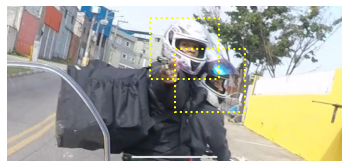

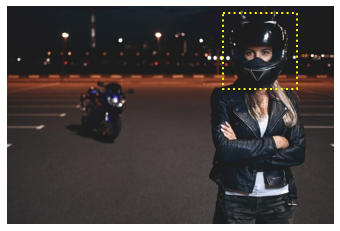

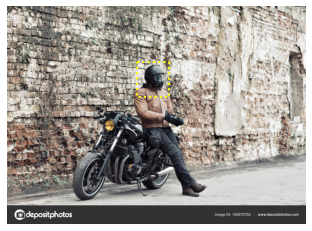

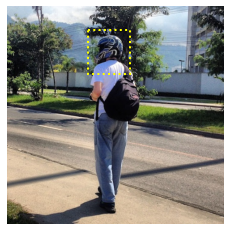

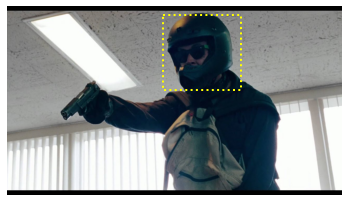

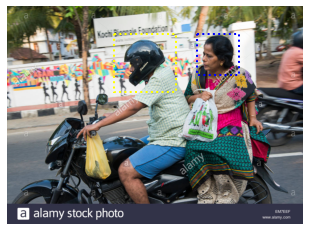

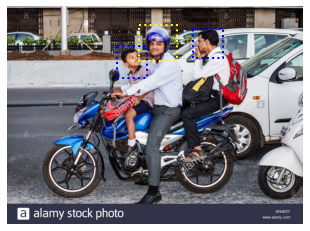

In [217]:
for img_path in test_list:

    im = Image.open(img_path)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)
    plt.axis("off")

    with open(img_path, mode="rb") as test_data:
        results = predictor.detect_image(project.id, publish_iteration_name, test_data)

    for prediction in results.predictions:
        if prediction.probability >= 0.5:
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (prediction.bounding_box.left*im.size[0], prediction.bounding_box.top*im.size[1]),
                prediction.bounding_box.width*im.size[0], prediction.bounding_box.height*im.size[1],
                linewidth=2, edgecolor=colors_dict[prediction.tag_name], facecolor='none', ls=":"
            )
            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()


In [205]:
for p in trainer.get_projects():
    if p.name == "Alerta de Capacete":
        for it in trainer.get_iterations(p.id):
            trainer.unpublish_iteration(p.id, it.id)
        trainer.delete_project(p.id)

|Item|Descrição|Docs|API|SDK|
|---|---|---|---|---|
|1.135.1.16.4|Detecção, reconhecimento e tracking de múltiplas pessoas e objetos de interesse nos vídeos previamente gravados ou em tempo real.|[Computer Vision](https://docs.microsoft.com/pt-br/azure/cognitive-services/computer-vision/concept-detecting-domain-content)|[Image Analysis v3.2](https://westus.dev.cognitive.microsoft.com/docs/services/computer-vision-v3-2/operations/56f91f2e778daf14a499f21b)|[Python](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/?view=azure-python)|

In [2]:
trainer_credentials = ApiKeyCredentials(in_headers={"Training-key": config.CS_GENERAL_SECRET})
trainer = CustomVisionTrainingClient(config.CS_GENERAL_ENDPOINT, trainer_credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": config.CS_GENERAL_SECRET})
predictor = CustomVisionPredictionClient(config.CS_GENERAL_ENDPOINT, prediction_credentials)
prediction_resource_id = config.prediction_resource_id

In [3]:
project_id = [t.id for t in trainer.get_projects() if t.name == 'Alerta de Capacete'][0]
publish_iteration_name = 'iteracao-01'

In [4]:
video_url = config.video_url_2
video_suffix = os.path.basename(video_url).split('.')[0]
video_path = utils.download_file(video_url)

cap = cv.VideoCapture(video_path)
source_fps = cap.get(cv.CAP_PROP_FPS)
target_fps = 6
freq_process = int(source_fps/target_fps)

i = 0
det = []

print('Sufixo do vídeo:', video_suffix)
print('FPS (origem):',source_fps, ' | Frequência das detecções:', freq_process)

Sufixo do vídeo: 135-1-5-moto
FPS (origem): 30.0  | Frequência das detecções: 5


In [5]:
while cap.isOpened():
    ret, frame = cap.read()
    if not (i % freq_process):
        det = utils.print_detection(cap, frame, predictor, project_id, publish_iteration_name, freq_process, det)

    if not ret:
        break
    i += 1

    if not i%100:
        print("Analisando frame de número", i)

Analisando frame de número 100
Analisando frame de número 200
Analisando frame de número 300
Analisando frame de número 400
Analisando frame de número 500
Analisando frame de número 600
Analisando frame de número 700
Analisando frame de número 800


In [14]:
with open(f'stlocal/det-{video_suffix}.txt', 'w') as fp:
    fp.write("\n".join(det))

In [20]:
det_path=f'./stlocal/tracking-{video_suffix}.txt'



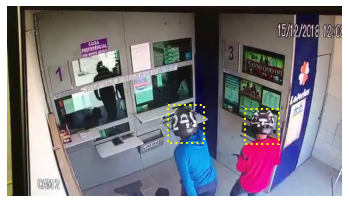

In [22]:
# video_path = utils.download_file(video_url)
# cap = cv.VideoCapture(video_path)
# cap.set(cv.CAP_PROP_POS_FRAMES, idx)
# ret, frame = cap.read()
# utils.print_detection(cap, frame, predictor, project_id, publish_iteration_name, flag_print=True)

In [ ]:
track_path = track_multiple_objects(det_path, video_suffix)

In [76]:
seq_dets = np.loadtxt(track_path, delimiter=',')
det_cols = ['internal_id','track_id', 'left', 'top', 'width', 'height', 'class', 'idx']
track_df = pd.DataFrame(seq_dets, columns=det_cols)

concat_df = []

for id in track_df.track_id.unique():
    id_df = track_df.loc[track_df.track_id == id, :].copy()
    if id_df.shape[0] >= 5:
        concat_df.append(utils.interpolate_detections(id_df))

concat_df = pd.concat(concat_df, axis = 0).sort_values("track_id")
concat_df['track_id'] = concat_df.track_id.rank(method='dense')


In [75]:
cap = cv.VideoCapture(video_path)
idx = cap.get(cv.CAP_PROP_POS_FRAMES)
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
idx_with_det = concat_df.idx.unique()
out_writer = cv.VideoWriter(f'tracking-{video_suffix}.mp4', cv.VideoWriter_fourcc(*"mp4v"), fps, (w,h))

while cap.isOpened():
    ret, frame = cap.read()
    idx = cap.get(cv.CAP_PROP_POS_FRAMES)
    if idx in idx_with_det:
        for det in concat_df.loc[concat_df.idx == idx, :].values:
            utils.circle_helmet((det[2],det[3],det[2]+det[4], det[3]+det[5]), frame, label=f'Capacete 0{int(det[1])}')
    out_writer.write(frame)
    if not ret:
        break
cap.release()
out_writer.release()